## Challenge

Do a little scraping or API-calling of your own.  Pick a new website and see what you can get out of it.  Expect that you'll run into bugs and blind alleys, and rely on your mentor to help you get through.  

Formally, your goal is to write a scraper that will:

1) Return specific pieces of information (rather than just downloading a whole page)  
2) Iterate over multiple pages/queries  
3) Save the data to your computer  

Once you have your data, compute some statistical summaries and/or visualizations that give you some new insights into your scraping topic of interest.  Write up a report from scraping code to summary and share it with your mentor.

### Scrapy Crawler

Using the J-Archive (https://www.j-archive.com/) database of Jeopardy games and scores, extract scores at the end of each round for each contestant.
1. Start with the July 1, 2019 Jeopardy game.
2. Find all score tables.
3. Separate score tables by row and assign to each contestant. The first row is the first contestant, etc.
- Iterate through each score table. Each score table represents a different round.
 Rounds will be designated as:
 - comm (first commerical)
 - first_rnd (end of first round)
 - double (end of Double Jeopardy)
 - final (end of Final Jeopardy)
 - coryat (Coryat score which uses 'natural' score with no additional betting from Daily Doubles or in Final Jeopardy).
5. Iterate through each contestant.
6. Extract next game and continue.
7. Stop after 20 calls.

In [ ]:
import scrapy
from scrapy.crawler import CrawlerProcess


class JArchiveSpider(scrapy.Spider):
    name = "JAS"
    
    # Start with the July 1, 2019 show
    start_urls = [ 'http://www.j-archive.com/showgame.php?game_id=6347' ]

    def parse(self, response):

        # iterate through each contestant
        for contestant in range(1,4):            
            rd = 1
            # look for scores at the end of each round
            for item in response.xpath('//td[{}][contains(@class,"score_positive") or contains(@class,"score_negative")]'.format(contestant)):
                # assign label by round
                if rd == 1:
                    yield {
                        'comm': item.xpath('text()').extract_first()
                    }
                    
                elif rd == 2:
                    yield {
                        'first_rnd': item.xpath('text()').extract_first()
                    }
                elif rd == 3:
                    yield {
                        'double': item.xpath('text()').extract_first()
                    }
                elif rd == 4:
                    yield {
                        'final': item.xpath('text()').extract_first()
                    }
                else:
                    yield {
                        'coryat': item.xpath('text()').extract_first()
                    }
                # iterate to next round
                rd += 1
                
        # get the link to the next game
        next_page = response.xpath('//*[@id="contestants_table"]//td[contains(@align,"right")]//@href').extract_first()
        
        # recursively call the spider to process the next game, if it exists
        if next_page is not None:
            next_page = 'http://www.j-archive.com/{}'.format(next_page)
            yield scrapy.Request(next_page, callback=self.parse)
            
    
process = CrawlerProcess({
    'FEED_FORMAT': 'json',
    'FEED_URI': 'JAS_Scores.json',
    'ROBOTSTXT_OBEY': True,
    'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True,
    'LOG_ENABLED': False,
    'CLOSESPIDER_PAGECOUNT' : 20
})
                                         

# Starting the crawler with our spider.
process.crawl(JArchiveSpider)
process.start()

### Data Cleaning

Load data

In [1]:
import pandas as pd

data0=pd.read_json('file://localhost/Users/yfsta/Documents/Thinkful/Unit 5/JAS_Scores.json', orient='records')
data0.head()

,comm,coryat,double,final,first_rnd
0,"$1,400",NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,"$4,200"
2,NaN,NaN,"$13,000",NaN,NaN
3,NaN,NaN,NaN,$0,NaN
4,NaN,"$15,000",NaN,NaN,NaN


Convert from DataFrame to array to make cleaning easier

In [2]:
data = data0.to_numpy().astype(str)

Get basic shape information

In [3]:
rows = len(data)
contestants = int(rows / 5)
games = int(contestants / 3)

print('There were {} contestants in {} games.'.format(contestants, games))

There were 57 contestants in 19 games.


Create a new DataFrame that separates scores by contestant

In [13]:
import numpy as np

scores = pd.DataFrame(columns = ['comm','first_rnd','double','final','coryat'], index = range(57))

i = 0
for r in data:
    if r[0] != 'nan':
        scores.iloc[i,0] = int(r[0].replace('$','').replace(',',''))
    elif r[4] != 'nan':
        scores.iloc[i,1] = int(r[4].replace('$','').replace(',',''))
    elif r[2] != 'nan':
        scores.iloc[i,2] = int(r[2].replace('$','').replace(',',''))
    elif r[3] != 'nan':
        scores.iloc[i,3] = int(r[3].replace('$','').replace(',',''))
    elif r[1] != 'nan':
        scores.iloc[i,4] = int(r[1].replace('$','').replace(',',''))
        i += 1    

In [14]:
scores.head()

,comm,first_rnd,double,final,coryat
0,1400,4200,13000,0,15000
1,2600,7300,17100,8199,14000
2,3000,5000,11800,0,11800
3,2000,6600,12400,8799,15400
4,3000,6000,16000,4000,15800


Calculate combined scores in each game.

In [47]:
game_scores = pd.DataFrame(columns = ['comm','first_rnd','double','final','coryat'], index = range(19))

for i in range(19):
    game_scores.iloc[i] = np.sum(scores.iloc[i*3:i*3 + 3])

In [49]:
game_scores.head()

,comm,first_rnd,double,final,coryat
0,7000,16500,41900,8199,40800
1,8400,17400,46200,45599,46800
2,3600,11000,36600,29400,31400
3,8000,18400,61800,84251,52000
4,8800,18600,40600,51799,47600


### Statistics

In [85]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

#### Contestant Score Distribution

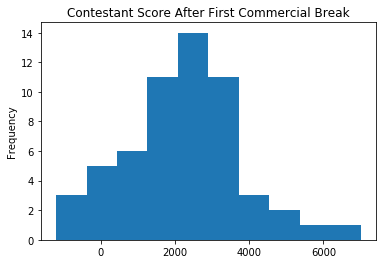

In [81]:
plt.figure()
scores.iloc[:,0].plot(kind='hist', title='Contestant Score After First Commercial Break')
plt.show()

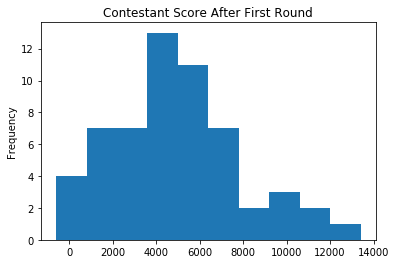

In [82]:
plt.figure()
scores.iloc[:,1].plot(kind='hist', title='Contestant Score After First Round')
plt.show()

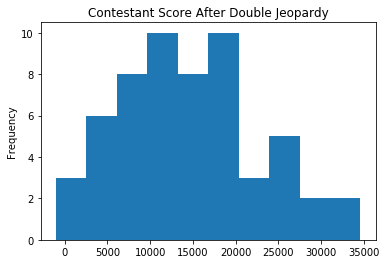

In [83]:
plt.figure()
scores.iloc[:,2].plot(kind='hist', title='Contestant Score After Double Jeopardy')
plt.show()

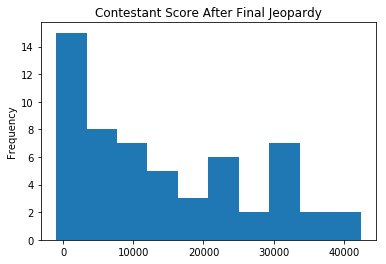

In [84]:
plt.figure()
scores.iloc[:,3].plot(kind='hist', title='Contestant Score After Final Jeopardy')
plt.show()

Although contestant scores show a fairly normal looking distribution after one round, they become less and less normal, with scores after Final Jeopardy highly skewed.

#### Score Box Plots

,comm,first_rnd,double,final
count,57.000000,57.000000,57.000000,57.000000
mean,2277.192982,4885.964912,14482.456140,14154.508772
std,1620.297321,2999.252204,8085.903139,12723.541508
min,-1200.000000,-600.000000,-1000.000000,-1000.000000
25%,1400.000000,3200.000000,8400.000000,3000.000000
50%,2200.000000,4800.000000,14200.000000,10399.000000
75%,3000.000000,6600.000000,18600.000000,24800.000000
max,7000.000000,13400.000000,34600.000000,42401.000000


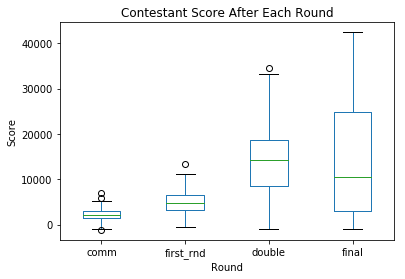

In [63]:
ax = scores.iloc[:,0:4].plot(kind='box', title='Contestant Score After Each Round')
ax.set_xlabel('Round')
ax.set_ylabel('Score')
scores.iloc[:,0:4].describe()

As one would expect, contestant score increases from the first commerical break to the end of Double Jeopardy. However, both mean and median for Final Jeopardy scores decrease. This is indicative of aggressive betting in Final Jeopardy. In contrast to previous rounds where each contestant chooses which questions to answer with higher likelihood of a correct answer, all contestants must attempt to answer the Final Jeopardy question, regardless of certainty. In addition, Final Jeopardy bets must be placed before even seeing the question.

,comm,first_rnd,double,final
count,19.000000,19.000000,19.000000,19.000000
mean,6831.578947,14657.894737,43447.368421,42463.526316
std,1958.756020,4290.210535,7876.150246,22723.633662
min,2000.000000,7600.000000,32400.000000,4400.000000
25%,6400.000000,11500.000000,37700.000000,27899.000000
50%,7000.000000,16000.000000,40800.000000,43001.000000
75%,8100.000000,18500.000000,47500.000000,58501.000000
max,10200.000000,20400.000000,61800.000000,84251.000000


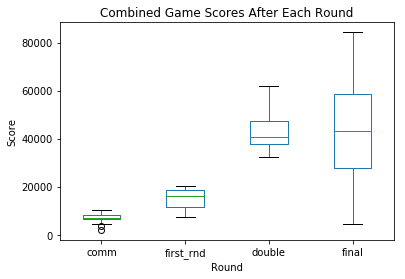

In [86]:
ax = (game_scores.iloc[:,0:4]).plot(kind='box',title='Combined Game Scores After Each Round')
ax.set_xlabel('Round')
ax.set_ylabel('Score')
(game_scores.iloc[:,0:4]).describe()

Interestingly, the standard deviation of combined game scores through the end of Double Jeopardy, is only slightly higher after the first commerical break and actually lower after Double Jeopardy, despite combining all three contestants. This suggests that although there may be a considerable amount of variability amongst contestants, games are more consistent.

#### Coryat Score

Coryat score was created to remove the effect of Daily Doubles and Final Jeopardy bets from scores. It is calculated using the 'natural' scores, without Daily Double wagers, and does not include Final Jeopardy.

In [94]:
import scipy.stats as stats

Compare whether there is a statistical difference between contestant scores after Double Jeoopardy and Coryat score using independent t-tests. Essentially, determine how significant Daily Double bets are to scores after Double Jeopardy.

In [99]:
stats.ttest_ind(scores['double'],scores['coryat'])

Ttest_indResult(statistic=1.0653847994942036, pvalue=0.28899319846336746)

There is no significant difference between contestant scores after Double Jeopardy and Coryat scores.

In [96]:
stats.ttest_ind(game_scores['double'],game_scores['coryat'])

Ttest_indResult(statistic=1.8478264327406548, pvalue=0.07285688598209665)

Although the p-value is considerably lower, there is not statistically significant difference in combined Double Jeopardy and Coryat game scores.